# **Big Mart Sales Prediction using Machine Learning**

# **Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import datetime as dt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

# **01. Initial Data Exploration**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Big Mart sales prediction/sales_data.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
# shape of the dataset
print(df.shape)
print('Number of Rows:', df.shape[0])
print('Number of columns:', df.shape[1])

(8523, 12)
Number of Rows: 8523
Number of columns: 12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
# summary statistics
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# **02. Data Preprocessing**

## **2.1 Handing duplicated values**

In [7]:
# checking for duplicated rows
df.duplicated().sum()

0

## **2.2 Handling the missing values**

In [8]:
# checking for the missing values
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# percentages of missing values
df.isnull().sum() / len(df) * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

* If the percentage of missing values in a dataset is less than 5%, it is often acceptable to drop the corresponding rows.
* However, when the percentage of missing values is high, it is necessary to employ appropriate strategies for handling them.

First, we focus on Filling the missing values in Numerical column "Item_Weight". Let's try the following methods and find what is the desired method for this column.
 - Mean/Median Imputation
 - Interpolation
 - K-Nearest Neighbors (KNN)

### **2.2.1 Handling the missing values in Numerical columns**

#### 1. Mean/Median Imputation

In [10]:
# calculate the mean & median of item_weight column
Item_Weight_mean = df['Item_Weight'].mean()
Item_Weight_median = df['Item_Weight'].median()

print(Item_Weight_mean,Item_Weight_median)

12.857645184135976 12.6


In [11]:
# Impute missing values in 'Item_Weight' column using mean & median
df['Item_Weight_mean'] = df['Item_Weight'].fillna(Item_Weight_mean)
df['Item_Weight_median'] = df['Item_Weight'].fillna(Item_Weight_median)

In [12]:
# calculate the variances original item weight & after imputing missimng values with mean and meadian
print("Original Weight variable variance:", df['Item_Weight'].var())
print("Item Weight variance after mean imputation:", df['Item_Weight_mean'].var())
print("Item Weight variance after median imputation:", df['Item_Weight_median'].var())

Original Weight variable variance: 21.561688259836558
Item Weight variance after mean imputation: 17.86012173506058
Item Weight variance after median imputation: 17.869561454073647


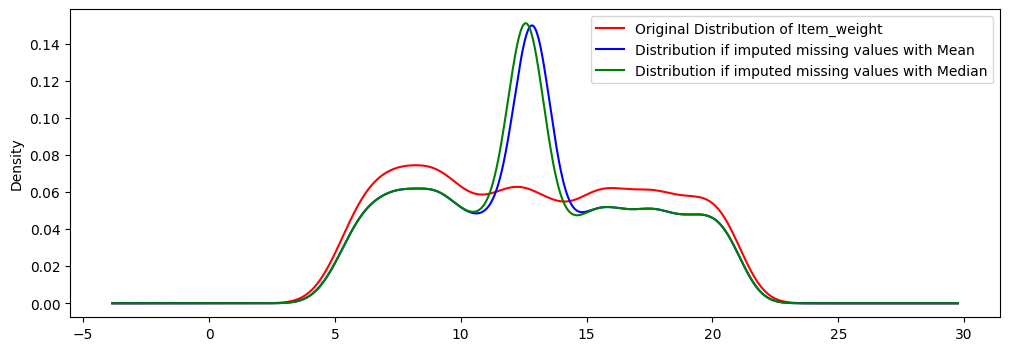

In [13]:
# Visualize the distribution of the 'Item_Weight' variable before and after imputation
plt.figure(figsize=(12, 4))

df['Item_Weight'].plot(kind = "kde", color='red', label="Original Distribution of Item_weight")
df['Item_Weight_mean'].plot(kind = "kde", color='blue', label = "Distribution if imputed missing values with Mean")
df['Item_Weight_median'].plot(kind = "kde", color='green', label = "Distribution if imputed missing values with Median")

plt.legend()
plt.show()

* After imputation, both the mean and median imputation methods cause the distribution to cluster more around the imputed values (mean and median).
* In some cases, this clustering around the mean or median may not be desirable.
* It can mask the true underlying distribution of the data, and it can also affect the results of statistical analyses.

<Axes: >

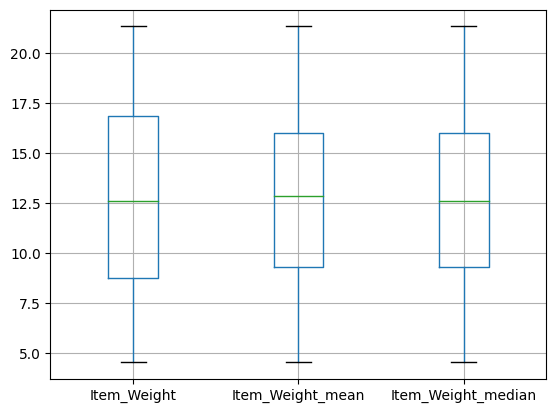

In [14]:
df[['Item_Weight','Item_Weight_mean','Item_Weight_median']].boxplot()

* After filling missing values with the mean and median, the **data's spread is reduced**, as seen by the compressed boxplots. This can be undesirable because it masks the data's natural variation.
* This is because missing values are replaced with the average or middle value, **reducing the influence of extreme values on the overall spread.**

#### 2. Interpolation

In [15]:
df['Item_Weight_interploate'] = df['Item_Weight'].interpolate(method="linear")

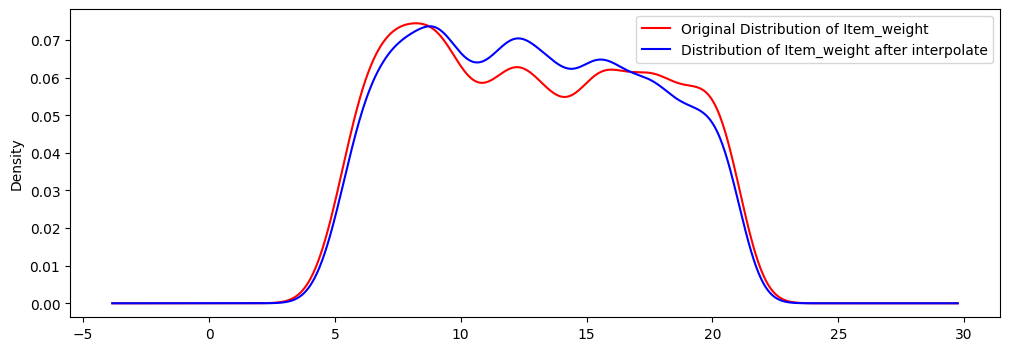

In [16]:
# Visualize the distribution of the 'Item_Weight' variable before and after interpolation
plt.figure(figsize=(12, 4))

df['Item_Weight'].plot(kind = "kde", color='red', label="Original Distribution of Item_weight")
df['Item_Weight_interploate'].plot(kind = "kde", color='blue', label = "Distribution of Item_weight after interpolate")

plt.legend()
plt.show()

* Here, the distributions appear very close, suggesting that **interpolation might be a better method for imputing missing values in the “item_weight” column** compared to other methods used earlier.
* This is because interpolation replaces missing data points with values estimated from surrounding data points, potentially preserving the original data distribution more accurately.

#### 3. K-Nearest Neighbors (KNN)

In [17]:
knn = KNNImputer(n_neighbors=10, weights="distance")

In [18]:
df['Item_weight_knn_imputer'] = knn.fit_transform(df[['Item_Weight']]).ravel()

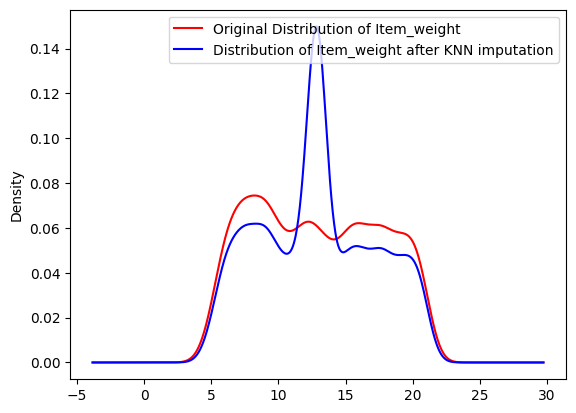

In [19]:
df['Item_Weight'].plot(kind = "kde", color='red', label="Original Distribution of Item_weight")
df['Item_weight_knn_imputer'].plot(kind = "kde", color='blue', label = "Distribution of Item_weight after KNN imputation")

plt.legend()
plt.show()

After KNN imputation, the distribution to cluster more around the imputed values which may not be desirable.

Therefore, it is better to go with the Interpolation method that results a distribution appear very close to before distribution.

In [20]:
# remove unnecessary columns resulting imputations
df = df.drop(['Item_Weight','Item_Weight_mean','Item_Weight_median','Item_weight_knn_imputer'], axis=1)

In [21]:
df.isnull().sum()

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight_interploate         0
dtype: int64

### **2.2.2 Handling the missing values in Categorical columns**

Before using the mode entire column to fill the missing values in Outlet_Size, check whether to fill the missing values based on the mode value according to Outlet_type.

In [22]:
mode_outlet_size_based_on_Type = df.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
mode_outlet_size_based_on_Type

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [23]:
missing_values = df['Outlet_Size'].isnull()

In [24]:
df.loc[missing_values,'Outlet_Size'] = df.loc[missing_values,'Outlet_Type'].apply(lambda x :mode_outlet_size_based_on_Type[x])

In [25]:
df.isnull().sum()

Item_Identifier              0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Weight_interploate      0
dtype: int64

## **2.3 Explore the other columns in Dataframe**

In [26]:
df.columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales', 'Item_Weight_interploate'],
      dtype='object')

### **Item_Fat_Content**

In [27]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [28]:
df.replace({'Item_Fat_Content':{'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'}},inplace=True)

In [29]:
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

### **Item_Visibility**

In [30]:
df['Item_Visibility'].value_counts().sort_values(ascending=False)

Item_Visibility
0.000000    526
0.076975      3
0.072317      2
0.104784      2
0.074613      2
           ... 
0.127234      1
0.029131      1
0.025886      1
0.029567      1
0.044878      1
Name: count, Length: 7880, dtype: int64

* Excluding the value 0, all other value counts are small numbers. However, there are 526 occurrences of the value 0. These occurrences likely represent missing values.

In [31]:
df['Item_Visibility_interpolate']=df['Item_Visibility'].replace(0,np.nan).interpolate(method='linear')

In [32]:
df.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047
1,DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278
2,FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760
3,FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755
4,NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751


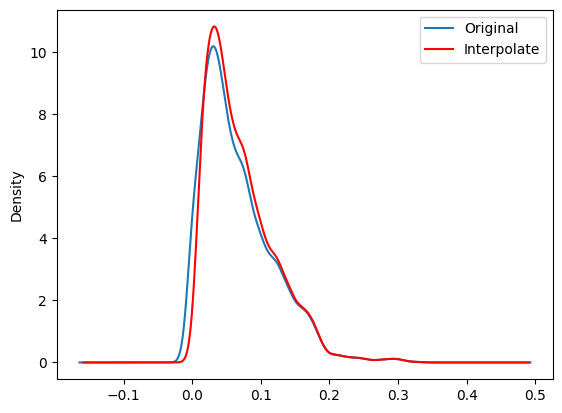

In [33]:
df['Item_Visibility'].plot(kind="kde",label="Original")
df['Item_Visibility_interpolate'].plot(kind="kde",color='red',label="Interpolate")

plt.legend()
plt.show()

In [34]:
df = df.drop('Item_Visibility',axis=1)

### **Item_Type**

In [35]:
df['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

### **Outlet_Identifier**

In [36]:
df['Item_Identifier'].value_counts()

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

* Item_Identifier is the Unique product ID. We can see a pattern of this ID with the first two letters.

In [37]:
df['Item_Identifier'] =df['Item_Identifier'].apply(lambda x : x[:2])

In [38]:
df['Item_Identifier'].value_counts()

Item_Identifier
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

* FD likely stands for "Food Drinks"
* NC likely stands "Non Consumables"
* DR likely stands for "Durable Goods" or "Durables"

### **Outlet_Establishment_Year**

In [39]:
df['Outlet_Establishment_Year'].value_counts()

Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: count, dtype: int64

In [40]:
current_year = dt.datetime.today().year
df['Outlet_age']= current_year - df['Outlet_Establishment_Year']

In [41]:
df['Outlet_age'].value_counts()

Outlet_age
39    1463
37     932
25     930
27     930
20     930
22     929
15     928
17     926
26     555
Name: count, dtype: int64

In [42]:
df = df.drop('Outlet_Establishment_Year', axis=1)

# **03. Exploratory Data Analysis (EDA)**

In [43]:
df.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Outlet_age
0,FD,Low Fat,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,9.30,0.016047,25
1,DR,Regular,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,5.92,0.019278,15
2,FD,Low Fat,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,17.50,0.016760,25
3,FD,Regular,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,19.20,0.015755,26
4,NC,Low Fat,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,8.93,0.014751,37


In [44]:
# list categorical and numerical features
numerical_features = df.select_dtypes(exclude=['object']).columns.to_list()
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

print("Numerical Features:",numerical_features)
print("Categorical Features:",categorical_features)

Numerical Features: ['Item_MRP', 'Item_Outlet_Sales', 'Item_Weight_interploate', 'Item_Visibility_interpolate', 'Outlet_age']
Categorical Features: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


## **Univariate Analysis**

### **Distribution of Dependent variable (Item_Outlet_Sales)**

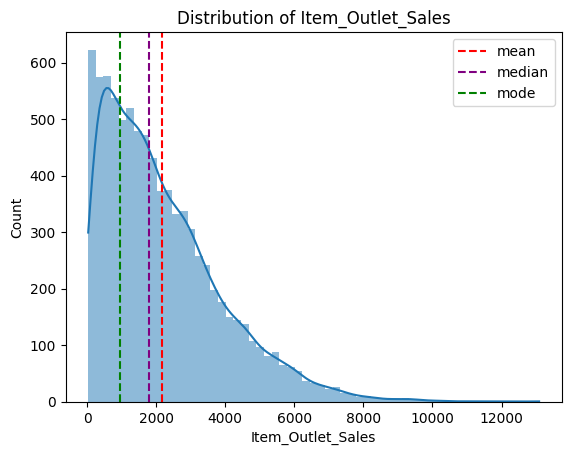

In [45]:
sns.histplot(df['Item_Outlet_Sales'], kde=True,  edgecolor='none')

# Add a vertical line at the mean, median, mode
plt.axvline(np.mean(df['Item_Outlet_Sales']), c='red', ls='--', label='mean')
plt.axvline(np.median(df['Item_Outlet_Sales']), c='purple', ls='--', label='median')
plt.axvline((df['Item_Outlet_Sales']).mode().iloc[0], c='green', ls='--', label='mode')


plt.title('Distribution of Item_Outlet_Sales')
plt.legend()

* The distribution of item outlet sales, which appears to be right skewed (positive skewed).
* This means that most stores have a low volume of sales, while a smaller number of stores have a high volume of sales.

### **Distribution of categorical independent variables**

#### **Item_Identifier**

<Axes: xlabel='Item_Identifier', ylabel='Count'>

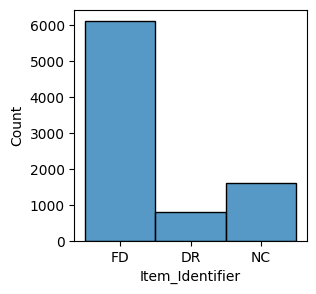

In [46]:
plt.figure(figsize=(3,3))
sns.histplot(df['Item_Identifier'])

* Food and Drinks have recorded the highest sales count.

#### **Item_Fat_Content**

<Axes: xlabel='Item_Fat_Content', ylabel='Count'>

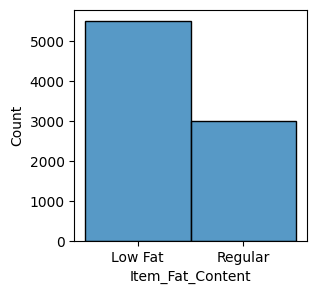

In [47]:
plt.figure(figsize=(3,3))
sns.histplot(df['Item_Fat_Content'])

* Low Fat items have recorded the highest sales count.

#### **Item_Type**

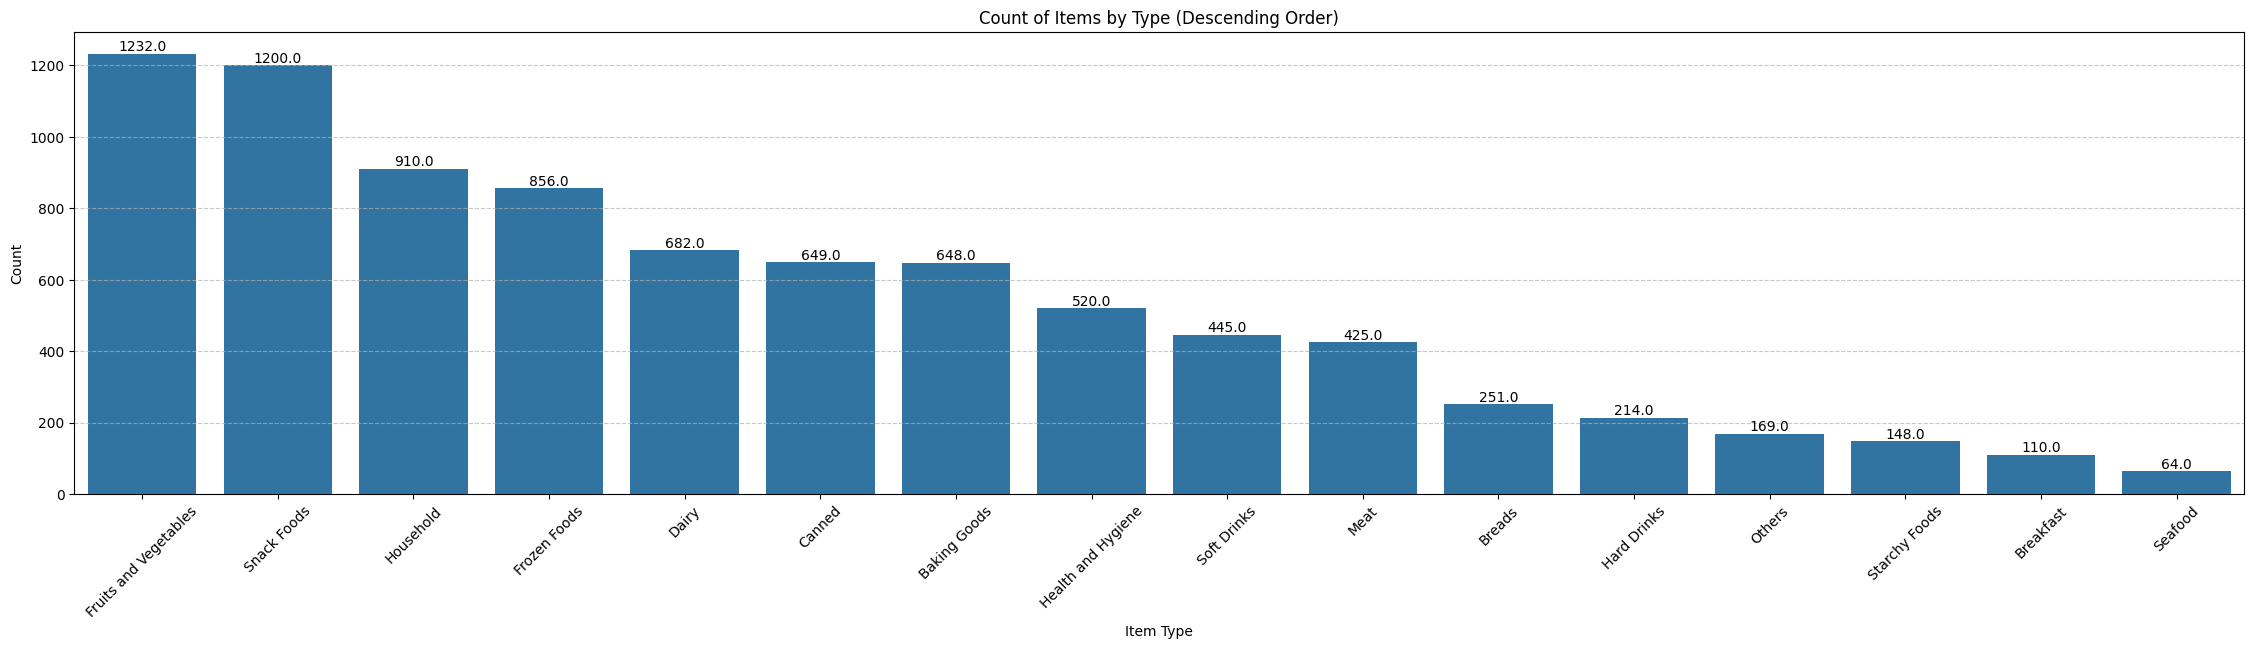

In [48]:
item_type_counts = df['Item_Type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(28, 6))
ax = sns.countplot(data=df, x='Item_Type', order=item_type_counts.index)
plt.xticks(rotation=45)
plt.xlabel('Item Type')
plt.ylabel('Count')
plt.title('Count of Items by Type (Descending Order)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

#### **Outlet_Location_Type**

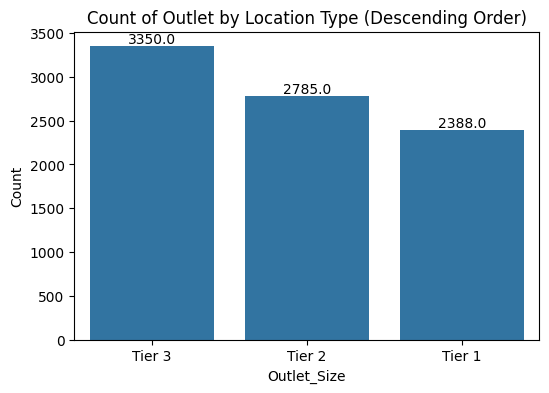

In [49]:
# Calculate the count of each Outlet_Location_Type and sort in descending order
Outlet_Location_Type_counts = df['Outlet_Location_Type'].value_counts().sort_values(ascending=False)

# Create a countplot for "Item_Type" in descending order
plt.figure(figsize=(6, 4))

ax = sns.countplot(data=df, x='Outlet_Location_Type', order = Outlet_Location_Type_counts.index)

plt.xlabel('Outlet_Size')
plt.ylabel('Count')
plt.title('Count of Outlet by Location Type (Descending Order)')

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

* Highest sales count have been achieved in Tier-3 Location.

### **Distribution of numerical independent variables**

##### **Distribution of Item_MRP**

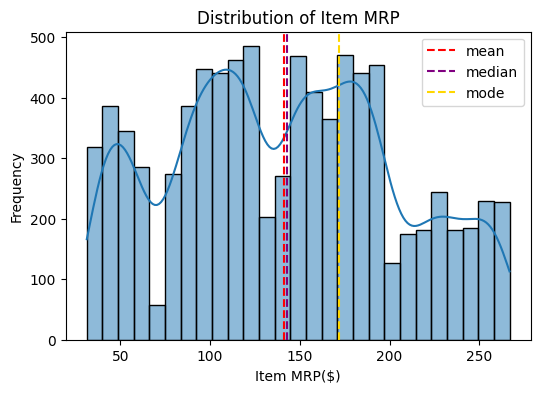

In [50]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Item_MRP'], kde=True)

plt.axvline(np.mean(df['Item_MRP']), c='red', ls='--', label='mean')
plt.axvline(np.median(df['Item_MRP']), c='purple', ls='--', label='median')
plt.axvline((df['Item_MRP']).mode().iloc[0], c='gold', ls='--', label='mode')

plt.title('Distribution of Item MRP')
plt.xlabel('Item MRP($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* There is a wide range of MRP values across the different item types.
* Some item types tend to have lower MRPs while others tend to have higher MRPs.
* The mean price & median price is close to $150.

##### **Distribution of Item_Weight**

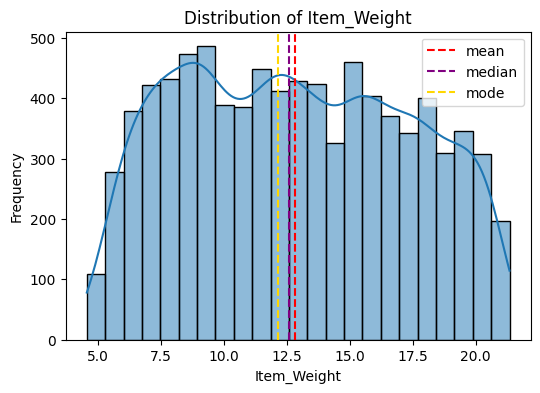

In [51]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Item_Weight_interploate'], kde=True)

plt.axvline(np.mean(df['Item_Weight_interploate']), c='red', ls='--', label='mean')
plt.axvline(np.median(df['Item_Weight_interploate']), c='purple', ls='--', label='median')
plt.axvline((df['Item_Weight_interploate']).mode().iloc[0], c='gold', ls='--', label='mode')

plt.title('Distribution of Item_Weight')
plt.xlabel('Item_Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<Axes: ylabel='Item_Weight_interploate'>

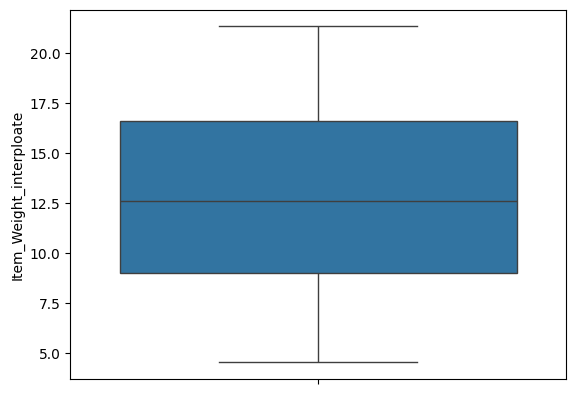

In [52]:
sns.boxplot(df['Item_Weight_interploate'])

##### **Distribution of Item_Visibility**

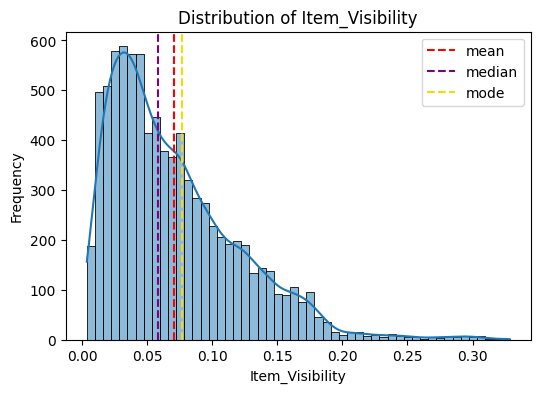

In [53]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Item_Visibility_interpolate'], kde=True)

plt.axvline(np.mean(df['Item_Visibility_interpolate']), c='red', ls='--', label='mean')
plt.axvline(np.median(df['Item_Visibility_interpolate']), c='purple', ls='--', label='median')
plt.axvline((df['Item_Visibility_interpolate']).mode().iloc[0], c='gold', ls='--', label='mode')

plt.title('Distribution of Item_Visibility')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequency')
plt.legend()
plt.show()

* The distribution is skewed to the right.
*This means that most items have lower visibility values. The median (0.10) is substantially lower than the mean (0.15), which confirms this skewness.

##### **Distribution of Outlet_age**

In [54]:
# Creating a new column for counting occurrences of each age
df['Outlet_age_count'] = 1

# Creating a pivot table
pivot_table_Outlet_age_count = pd.pivot_table(df, values='Outlet_age_count', index='Outlet_age', aggfunc='sum')
print(pivot_table_Outlet_age_count)

            Outlet_age_count
Outlet_age                  
15                       928
17                       926
20                       930
22                       929
25                       930
26                       555
27                       930
37                       932
39                      1463


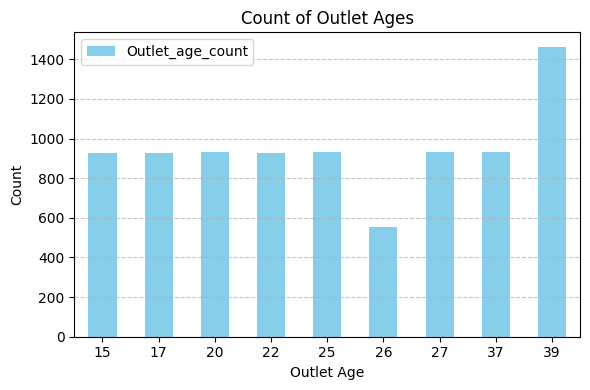

In [55]:
pivot_table_Outlet_age_count.plot(kind='bar', color='skyblue', figsize=(6, 4))
plt.title('Count of Outlet Ages')
plt.xlabel('Outlet Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* The age with the highest count of outlets is 39 years old.

In [56]:
df.drop('Outlet_age_count', axis=1, inplace=True)

## **Bivariate Analysis**

In [57]:
pv_outlet_identifier_age = pd.pivot_table(df, values='Outlet_age', index='Outlet_Identifier', aggfunc='mean')
print(pv_outlet_identifier_age)

                   Outlet_age
Outlet_Identifier            
OUT010                     26
OUT013                     37
OUT017                     17
OUT018                     15
OUT019                     39
OUT027                     39
OUT035                     20
OUT045                     22
OUT046                     27
OUT049                     25


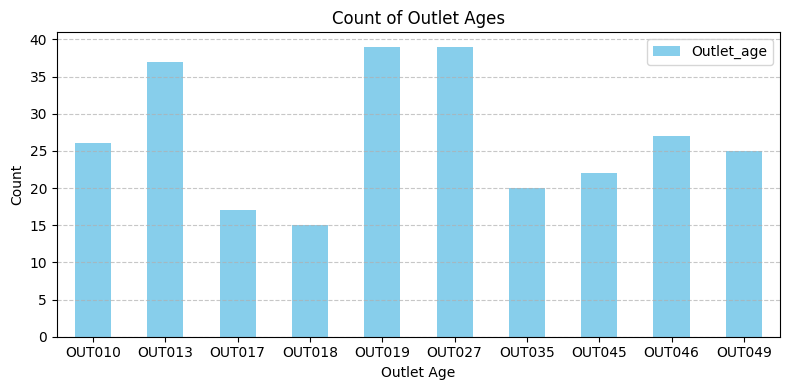

In [58]:
pv_outlet_identifier_age.plot(kind='bar', color='skyblue', figsize=(8, 4))
plt.title('Count of Outlet Ages')
plt.xlabel('Outlet Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* The outlets OUT019 and OUT027 both have the highest age of 39 years. Therefore, either OUT019 or OUT027 could be considered as the oldest outlets.
* OUT018 is the newest outlet.

### **Identify the relationship between Outlet_age & Item_Outlet_Sales**

<Axes: xlabel='Outlet_age', ylabel='Item_Outlet_Sales'>

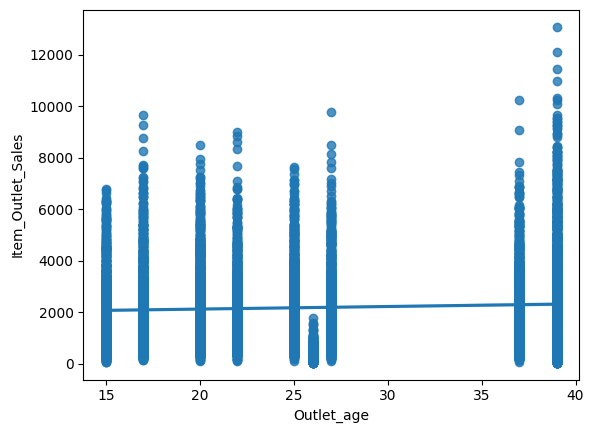

In [59]:
sns.regplot(data=df, x='Outlet_age', y='Item_Outlet_Sales')

In [60]:
correlation = df['Outlet_age'].corr(df['Item_Outlet_Sales'])
print("Correlation between Outlet_age and Item_Outlet_Sales:", correlation)

Correlation between Outlet_age and Item_Outlet_Sales: 0.04913497044082087


* The correlation coefficient is close to zero (0.049).
*It suggests a **very weak positive linear relationship** between the age of the outlet and the sales of items in that outlet.

### **Identify the relationship between Item_MRP & Item_Outlet_Sales**

<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

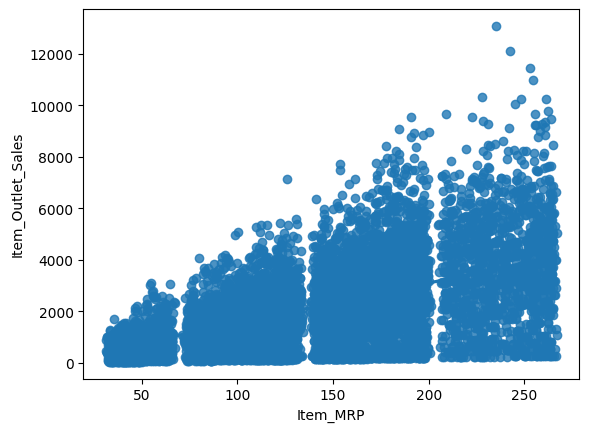

In [61]:
sns.regplot(data=df, x='Item_MRP', y='Item_Outlet_Sales')

In [62]:
correlation = df['Item_MRP'].corr(df['Item_Outlet_Sales'])
print("Correlation between Item_MRP and Item_Outlet_Sales:", correlation)

Correlation between Item_MRP and Item_Outlet_Sales: 0.5675744466569194


* There is a moderately positive correlation between between Item_MRP and Item_Outlet_Sales.
* It suggests that as the maximum retail price of items increases, outlet sales tend to increase, although the strength of the relationship is not extremely high.

### **Identify the relationship between Item_Weight & Item_Outlet_Sales**

<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

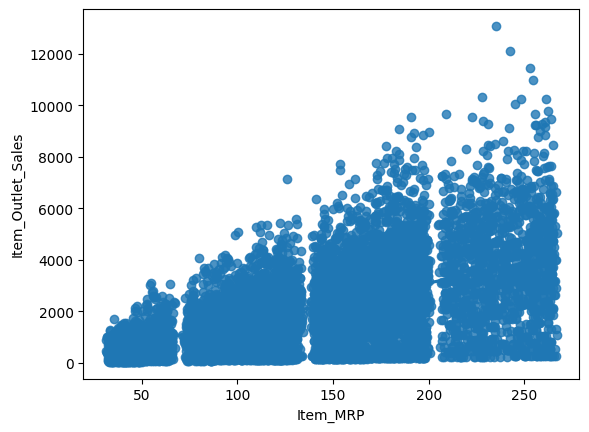

In [63]:
sns.regplot(data=df, x='Item_MRP', y='Item_Outlet_Sales')

In [64]:
correlation = df['Item_Weight_interploate'].corr(df['Item_Outlet_Sales'])
print("Correlation between Item_Weight_interploate and Item_Outlet_Sales:", correlation)

Correlation between Item_Weight_interploate and Item_Outlet_Sales: 0.014535651743138842


* There is a very weak positive correlation between the two variables, suggesting that **there is no meaningful relationship between item weight and outlet sales.**

### **Calculate the correlation coefficients between all pairs of numerical columns**

In [65]:
df[numerical_features].corr()

,Item_MRP,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Outlet_age
Item_MRP,1.000000,0.567574,0.024839,-0.006544,-0.005020
Item_Outlet_Sales,0.567574,1.000000,0.014536,-0.133874,0.049135
Item_Weight_interploate,0.024839,0.014536,1.000000,-0.012096,-0.001220
Item_Visibility_interpolate,-0.006544,-0.133874,-0.012096,1.000000,0.077071
Outlet_age,-0.005020,0.049135,-0.001220,0.077071,1.000000


<Axes: >

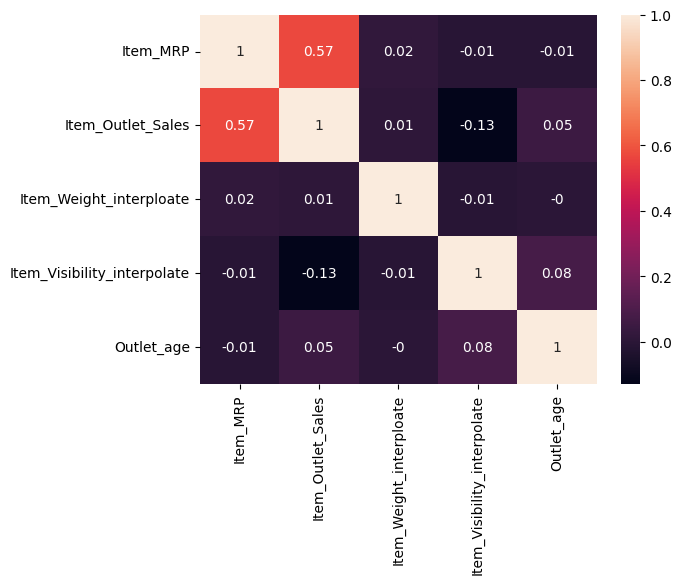

In [66]:
sns.heatmap(np.round(df[numerical_features].corr(),2), annot=True)

* Item_Outlet_Sales has the strongest positive correlation with Item_MRP  among the five variables. However, there is a moderately positive correlation between between Item_MRP and Item_Outlet_Sales.

# **03. Ordinal Encoding for Categorical Data using Scikit-learn**

In [67]:
oe = OrdinalEncoder()

In [68]:
for col in categorical_features:
  df[col] = oe.fit_transform(df[col].values.reshape(-1, 1))

In [69]:
df.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight_interploate,Item_Visibility_interpolate,Outlet_age
0,1.0,0.0,4.0,249.8092,9.0,1.0,0.0,1.0,3735.1380,9.30,0.016047,25
1,0.0,1.0,14.0,48.2692,3.0,1.0,2.0,2.0,443.4228,5.92,0.019278,15
2,1.0,0.0,10.0,141.6180,9.0,1.0,0.0,1.0,2097.2700,17.50,0.016760,25
3,1.0,1.0,6.0,182.0950,0.0,2.0,2.0,0.0,732.3800,19.20,0.015755,26
4,2.0,0.0,9.0,53.8614,1.0,0.0,2.0,1.0,994.7052,8.93,0.014751,37


# **04. Comparing Random Forest and XGBoost for Regression Analysis**

In [70]:
# Preparing Features and Target Variable
x = df.drop('Item_Outlet_Sales',axis=1)
y = df['Item_Outlet_Sales']

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [72]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6818, 11), (6818,), (1705, 11), (1705,))

## **Random Forest Regressor**

In [73]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

In [74]:
# Calculate Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Mean Absolute Error (MAE):", mae_rf)

# Calculate R-squared (R2) score
r2_rf = r2_score(y_test, y_pred_rf)
print("R-squared (R2) score:", r2_rf)

Mean Absolute Error (MAE): 815.6480993231671
R-squared (R2) score: 0.5500868790695546


## **XGBRFRegressor**

In [75]:
xg = XGBRFRegressor(n_estimators = 100, random_state = 0)
xg.fit(x_train, y_train)
y_pred_xg = xg.predict(x_test)

In [76]:
# Calculate Mean Absolute Error (MAE)
mae_xg = mean_absolute_error(y_test, y_pred_xg)
print("Mean Absolute Error (MAE):", mae_xg)

# Calculate R-squared (R2) score
r2_xg = r2_score(y_test, y_pred_xg)
print("R-squared (R2) score:", r2_xg)

Mean Absolute Error (MAE): 775.2887799913369
R-squared (R2) score: 0.5903437543005203


### **XGBRFRegressor Feature importances**

In [77]:
best_features = xg.fit(x,y)
pd.DataFrame({
    'feature':x.columns,
    'XGBRF_importance':best_features.feature_importances_

}).sort_values(by='XGBRF_importance',ascending=False)

,feature,XGBRF_importance
7,Outlet_Type,0.433528
10,Outlet_age,0.169237
3,Item_MRP,0.156150
4,Outlet_Identifier,0.111862
5,Outlet_Size,0.097972
6,Outlet_Location_Type,0.022317
9,Item_Visibility_interpolate,0.002837
8,Item_Weight_interploate,0.002686
2,Item_Type,0.001808
0,Item_Identifier,0.000973


In [78]:
xg_final = XGBRFRegressor(n_estimators = 100, random_state = 0)
rfe = RFE(xg_final, n_features_to_select=4)
results = rfe.fit(x,y)

In [79]:
x_selected = x.columns[results.support_]

In [80]:
x_train_new = x_train[x_selected]
x_test_new = x_test[x_selected]

In [81]:
xg_final = XGBRFRegressor(n_estimators = 100, random_state = 0)
xg_final.fit(x_train_new, y_train)
y_pred_xg = xg_final.predict(x_test_new)

In [82]:
# Calculate Mean Absolute Error (MAE)
mae_xg = mean_absolute_error(y_test, y_pred_xg)
print("Mean Absolute Error (MAE):", mae_xg)

# Calculate R-squared (R2) score
r2_xg = r2_score(y_test, y_pred_xg)
print("R-squared (R2) score:", r2_xg)

Mean Absolute Error (MAE): 769.9928870184058
R-squared (R2) score: 0.5950703902327229


## **Prediction on Unseen Data**

In [83]:
x_train_new.sample(2)

,Item_MRP,Outlet_Identifier,Outlet_Type,Outlet_age
617,59.9878,1.0,1.0,37
7642,110.8570,9.0,1.0,25


In [84]:
pred_array = np.array([182, 3.0, 1.0, 22]).reshape(1,4)

In [85]:
predicted_outlet_sales = xg_final.predict(pred_array)
predicted_outlet_sales.round(2)

array([2978.16], dtype=float32)

In [86]:
print(f"Sales Value is between {predicted_outlet_sales-769.99} and {predicted_outlet_sales+769.99}")

Sales Value is between [2208.1672] and [3748.1472]


Save Model Using Joblib

In [87]:
import joblib

In [88]:
joblib.dump(xg_final,'bigmart_sales_prediction_model')

['bigmart_sales_prediction_model']

In [89]:
model = joblib.load('bigmart_sales_prediction_model')

In [90]:
pred_array = np.array([350, 2.0, 3.0, 48]).reshape(1,4)

In [91]:
predicted_outlet_sales = xg_final.predict(pred_array)
predicted_outlet_sales.round(2)

array([5041.5], dtype=float32)

In [92]:
print(f"Sales Value is between {predicted_outlet_sales-769.99} and {predicted_outlet_sales+769.99}")

Sales Value is between [4271.5127] and [5811.493]
